In [292]:
# !pip install cvxpy
# !pip install scipy==1.15.1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm
import os
from sklearn.metrics import f1_score
import json
import pandas as pd
from enum import Enum
import cvxpy as cp
import csv

(CVXPY) Apr 03 09:33:30 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


Data generation

In [4]:
class MatrixType(Enum):
    """
    Enum representing different available matrices in the data directory
    """
    SCALE_FREE = "Scale_Free_Laplacian"
    ERDOS_RENYI = "Erdos_Renyi_Laplacian"
    SMALL_WORLD = "Small_World_Laplacian"
    GRID_GRAPH = "Grid_Graph_Laplacian"
    BUS_33_MODIFIED = "33bus_modified_ybus"
    WATER_NETWORK = "water_network"

In [5]:
def ensure_positive_definite(M, epsilon=1, min_threshold=1e-3):
    """
    Ensure M is well-conditioned ; add small value to diagonal if needed
    """
    min_eig = np.min(np.linalg.eigvals(M))
    
    if min_eig < min_threshold:
        print(f"Minimum eigenvalue too small ({min_eig:.2e}), adding {epsilon} to diagonal elements.")
        M += np.eye(M.shape[0]) * (abs(min_eig) + epsilon)
    
    return M

In [6]:
def load_B(matrix_type: MatrixType, data_dir='Data'):
    """
    Load a specific matrix from Data directory
    """
    matrix_name = matrix_type.value
    file_path = os.path.join(data_dir, matrix_name + '.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Matrix file '{matrix_name}' not found in {data_dir}.")

    B = pd.read_csv(file_path, header=None).values  # into a numpy array
    
    return ensure_positive_definite(B)

In [7]:
for matrix_type in MatrixType:
    B = load_B(matrix_type)
    print(f'Is {matrix_type.value} symmetric: {la.issymmetric(B)}')

Is Scale_Free_Laplacian symmetric: True
Is Erdos_Renyi_Laplacian symmetric: True
Is Small_World_Laplacian symmetric: True
Is Grid_Graph_Laplacian symmetric: True
Minimum eigenvalue too small (-2.50e-15), adding 1 to diagonal elements.
Is 33bus_modified_ybus symmetric: True
Is water_network symmetric: True


In [8]:
def generate_sparse_covariance(B, sample_scaling=1.0, random_seed=19):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """
    np.random.seed(random_seed)

    n = len(B)
    # print("Len of B", B)

    # Mask diagonal of B matrix
    B_no_diag = B.copy()
    np.fill_diagonal(B_no_diag, 0)

    # Now count the number of non-zero elements per row (true degree)
    d = np.max(np.sum(B_no_diag != 0, axis=1))
    # print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))
    print(f"p:{n}, d:{d} tou: {sample_scaling}, N: {N}")

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples.real)

    return S, N

Minimum eigenvalue too small (-2.50e-15), adding 1 to diagonal elements.
p:33, d:3 tou: 1, N: 31
Number of samples 31
F1 norm 1.427626272008598


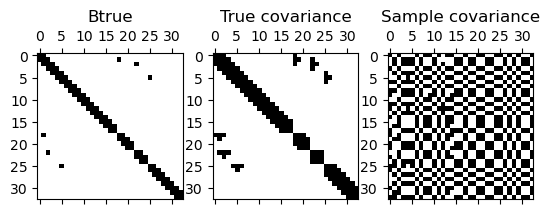

In [9]:
B = load_B(MatrixType.BUS_33_MODIFIED)
S, N = generate_sparse_covariance(B, sample_scaling=1)
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
plt.spy(B@B)
plt.title("True covariance")
plt.subplot(1,3,3)
plt.spy(np.linalg.inv(S)>0.1)
plt.title("Sample covariance")
print("Number of samples", N)
print("F1 norm", np.linalg.norm(np.linalg.inv(B@B)-S, ord="fro"))

Algorithm

In [10]:
def soft_thresholding_offdiag(B_new, Lambda, lambda_, rho):
    """
    Applies off-diagonal soft-thresholding.
    """
    
    # Compute argument for soft-thresholding
    X = rho * B_new + Lambda
    
    # Create a copy to modify
    Z_new = X.copy()
    
    # Off-diagonal mask
    mask_offdiag = ~np.eye(X.shape[0], dtype=bool)

    # Apply soft-thresholding only to off-diagonal elements
    Z_new[mask_offdiag] = np.sign(X[mask_offdiag]) * np.maximum(np.abs(X[mask_offdiag]) - lambda_, 0)

    return Z_new


In [11]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

In [12]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        # if k % 5 == 0:  # Print every 5 iterations
        #     print(f"Iteration {k}, Error: {err:.2e}")
        
        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return (X+X.T)/2

In [13]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, abs_tol=1e-4, rel_tol=1e-3,log_history=True, log_dir="admm_logs"):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    if log_history:
        os.makedirs(log_dir, exist_ok=True)
        log_path = os.path.join(log_dir, "admm_history.csv")
        with open(log_path, "w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["iter", "objval", "r_norm", "eps_pri", "s_norm", "eps_dual"])

    for k in range(max_iter):
        Z_prev = Z.copy()

        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding_offdiag(B_new, Lambda, lambda_, rho)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # Residuals
        r_norm = np.linalg.norm(B_new - Z_new, ord='fro')  # primal
        s_norm = np.linalg.norm(rho * (Z_new - Z_prev), ord='fro')  # dual

        # Stopping criterion - similar to Boyd et al - https://web.stanford.edu/~boyd/papers/admm/covsel/covsel.html
        eps_pri = np.sqrt(n * n) * abs_tol + rel_tol * max(np.linalg.norm(B_new, 'fro'), np.linalg.norm(Z_new, 'fro'))
        eps_dual = np.sqrt(n * n) * abs_tol + rel_tol * np.linalg.norm(Lambda_new, 'fro')

        objval = np.trace(B_new @ S) - np.log(np.linalg.det(B_new) + 1e-8) + lambda_ * np.sum(np.abs(B_new * (~np.eye(n, dtype=bool))))

        if log_history:
            with open(log_path, "a", newline='') as f:
                writer = csv.writer(f)
                writer.writerow([k, objval, r_norm, eps_pri, s_norm, eps_dual])

        # Check convergence
        # if k % 5 == 0 or (r_norm < eps_pri and s_norm < eps_dual):
        #     print(f"Iter {k:3d} | r: {r_norm:.2e} (≤ {eps_pri:.2e}) | s: {s_norm:.2e} (≤ {eps_dual:.2e}) | Obj: {objval:.4f}")

        if r_norm < eps_pri and s_norm < eps_dual:
            print(f"ADMM converged at iter {k+1}.")
            break
        elif k == max_iter - 1:
            print("ADMM did not converge within max iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [14]:
def find_sqrt(S, epsilon=1e-8):
    """
    Compute a PSD-preserving square root of S via eigendecomposition.
    """
    evalue,evec = la.eigh(S)
    Lambda = np.diag(evalue)
    R = la.sqrtm(Lambda)
    V = evec@R
    return V


In [15]:
def slnscl_precision_matrix(S, lambda_, max_iter=1000, tol=1e-4, log_dir = "slnscl_logs", log_history = True, trial_id=-1):
    """
    Solve the SLNSCL objective using CVXPY.
    """
    n = S.shape[0]
    S = S
    V = find_sqrt(S)
    
    B_hat = cp.Variable(shape=(n,n), PSD = True)
    objective = cp.Minimize(-2*cp.log_det(B_hat) +  (cp.norm(B_hat@V, "fro"))**2 + lambda_*cp.sum(cp.abs(B_hat)))    

    # Solve it
    problem = cp.Problem(objective)
    try:
        problem.solve(solver=cp.SCS, verbose=False, max_iters=max_iter, eps=tol)
    except Exception as e:
        print("CVXPY solver failed:", e)
        print("Min eigenvalue of S:", np.min(np.linalg.eigvalsh(S)))
        print("Any NaNs in S:", np.isnan(S).any())
        raise

    # Optimality check
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"SLNSCL optimization failed with status: {problem.status}")
    
    # Save solver stats (if logging enabled)
    if log_history:
        stats_path = os.path.join(log_dir, "slnscl_solver_stats.jsonl")
        with open(stats_path, "a") as f:
            json.dump({
                "trial": trial_id,
                "status": problem.status,
                "lambda": lambda_,
                "objective_value": problem.value,
                "solve_time": problem.solver_stats.solve_time,
                "num_iters": problem.solver_stats.num_iters,
                "solver": problem.solver_stats.solver_name,
                "setup_time": problem.solver_stats.setup_time,
                # "extra_stats": problem.solver_stats.extra_stats,
            }, f)
            f.write("\n")

    return B_hat.value


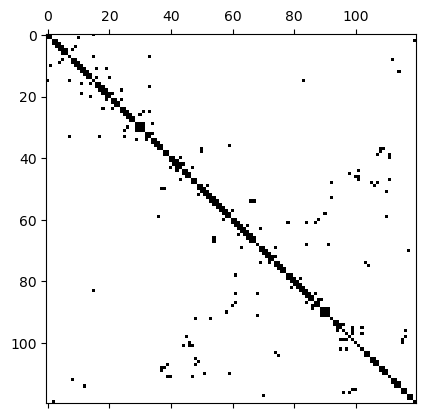

In [16]:
plt.spy(load_B(MatrixType.WATER_NETWORK))

Simple experiment - slnscl

In [21]:
B = load_B(matrix_type=MatrixType.WATER_NETWORK)

In [22]:
S, N = generate_sparse_covariance(B, sample_scaling=10)

print(f'Number of samples used: {N}')
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.1  # Regularization strength
max_iter = 1000  # Maximum number of iterations
tol = 1e-6  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = slnscl_precision_matrix(S, lambda_, max_iter=max_iter, tol =tol, log_history= True)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

p:120, d:5 tou: 10, N: 1196
Number of samples used: 1196
Estimated Precision Matrix (B estimate):
[[ 2.53009829e+00 -6.73441357e-01 -2.01219927e-10 ...  3.51162675e-08
  -1.11555413e-08 -2.95118519e-08]
 [-6.73441357e-01  2.39694997e+00 -1.86792788e-08 ...  3.17122574e-08
  -1.67192296e-08 -5.41039401e-08]
 [-2.01219927e-10 -1.86792788e-08  3.35718333e+00 ... -5.04703708e-08
  -1.09495780e-07 -7.18540447e-01]
 ...
 [ 3.51162675e-08  3.17122574e-08 -5.04703708e-08 ...  2.50937575e+00
  -7.21618757e-01 -6.47291805e-08]
 [-1.11555413e-08 -1.67192296e-08 -1.09495780e-07 ... -7.21618757e-01
   1.76332500e+00 -9.57226776e-08]
 [-2.95118519e-08 -5.41039401e-08 -7.18540447e-01 ... -6.47291805e-08
  -9.57226776e-08  1.82731490e+00]]


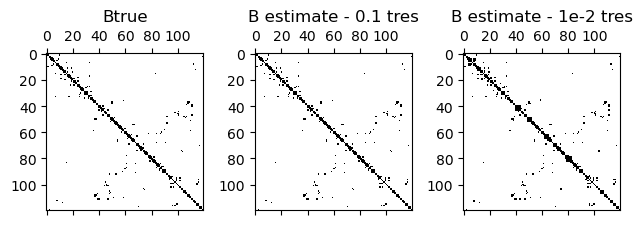

In [23]:
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.1))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")
plt.show()

Simple experiment - ADMM

In [109]:
B = load_B(matrix_type=MatrixType.BUS_33_MODIFIED)


Minimum eigenvalue too small (-2.50e-15), adding 1 to diagonal elements.


In [117]:
S, N = generate_sparse_covariance(B, sample_scaling=2)

print(f'Number of samples used: {N}')
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.1  # Regularization strength
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-5  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, abs_tol= tol, rel_tol= tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 4
Number of samples used: 108
Iteration 0, Error: 5.53e-01
Iteration 5, Error: 3.21e-04
Iter   0 | r: 1.14e+00 (≤ 3.56e-04) | s: 5.34e+00 (≤ 3.11e-04) | Obj: 55.5657
Iteration 0, Error: 3.77e-01
Iteration 5, Error: 4.86e-15
Iteration 0, Error: 3.28e-01
Iteration 5, Error: 5.31e-15
Iteration 0, Error: 1.92e-01
Iteration 0, Error: 1.27e-01
Iteration 0, Error: 9.78e-02
Iter   5 | r: 1.95e-01 (≤ 4.15e-04) | s: 6.08e-01 (≤ 3.21e-04) | Obj: 49.0879
Iteration 0, Error: 7.99e-02
Iteration 0, Error: 6.72e-02
Iteration 0, Error: 5.64e-02
Iteration 0, Error: 4.75e-02
Iteration 0, Error: 3.76e-02
Iter  10 | r: 7.36e-02 (≤ 4.29e-04) | s: 2.14e-01 (≤ 3.23e-04) | Obj: 48.3728
Iteration 0, Error: 3.02e-02
Iteration 0, Error: 2.48e-02
Iteration 0, Error: 1.99e-02
Iteration 0, Error: 1.58e-02
Iteration 0, Error: 1.24e-02
Iter  15 | r: 4.99e-02 (≤ 4.34e-04) | s: 8.28e-02 (≤ 3.23e-04) | Obj: 48.1932
Iteration 0, Error: 9.91e-03
Iteration 0, Error: 8.22e-03
Iteration 0, Error: 6.64e-03
Iter

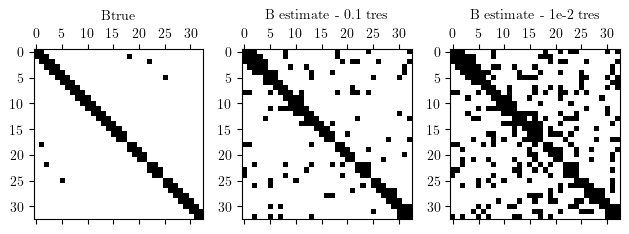

In [111]:
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.1))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")
plt.show()

Experimentation

In [15]:
import time

In [16]:
def evaluate_f1_vs_lambda(
        lambda_values, B, sample_scaling=1.0,
        rho=1.0, max_iter=100, tol=1e-4,
        threshold=1e-4, save_plots = False, 
        log_dir="experiment_logs",
        method= "ADMM"):
    """
    Evaluate f1 scores, 
    excluding diagonal elements, for each lambda.
    """
    
    B = np.array(B)
    n = B.shape[0]
    
    # Generate sample covariance S and sample size N
    S, N = generate_sparse_covariance(B, sample_scaling=sample_scaling)

    print("Number of samples:", N)
    print("Minimum eigenvalue of B:", np.min(np.linalg.eigvals(B)))

    # Ground-truth adjacency (full)
    ground_truth_adjacency = (B != 0).astype(int)

    # Exclude diagonals via a mask
    mask_offdiag = ~np.eye(n, dtype=bool)

    metrics = {
        "lambda": [],
        "f1": [],
    }

    for lambda_ in lambda_values:
        if method == "ADMM":
            start = time.perf_counter()
            B_est = admm_precision_matrix(S, lambda_, rho, max_iter, tol)
            end = time.perf_counter()
            print(f"ADMM estimation time for lambda: {lambda_} is {end - start:.4f} seconds")
        else:
            start = time.perf_counter()
            B_est = slnscl_precision_matrix(S, lambda_)
            end = time.perf_counter()
            print(f"CVXPY estimation time for lambda: {lambda_} is {end - start:.4f} seconds")

        # Threshold the estimate
        B_est_thresholded = hard_threshold(B_est, threshold)

        if save_plots:
            # Plot and save the sparsity patterns (optional, can remove if not needed)
            plt.figure(figsize=(6, 12))
            
            plt.subplot(1, 2, 1)
            plt.spy(B)
            plt.title("B (True)", fontsize=16)

            plt.subplot(1, 2, 2)
            plt.spy(B_est_thresholded)
            plt.title("B_est (Estimated)", fontsize=16)

            plot_path = os.path.join(log_dir, f"sparsity_lambda_{lambda_:.3f}.png")
            plt.savefig(plot_path)
            plt.close()
            
        
        predicted_adjacency = (B_est_thresholded != 0).astype(int)
        gt_offdiag = ground_truth_adjacency[mask_offdiag]
        pred_offdiag = predicted_adjacency[mask_offdiag]

        f1 = f1_score(gt_offdiag, pred_offdiag)

        # Store the results
        metrics["lambda"].append(lambda_)
        metrics["f1"].append(f1)

    return metrics

In [48]:
# Updated main loop
sample_scaling = 1

matrix_type = MatrixType.SMALL_WORLD
method = "ADMM"
# method = "CVXPY"
B = load_B(matrix_type)
print(f'Is B pd: {np.min(np.linalg.eigvals(B))>0}')

log_dir = f"experiment_logs/{method}/{matrix_type._value_}/{sample_scaling}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0,1, 10).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 1.0,
    "max_iter": 1000,
    "tol": 1e-4,
    "threshold": 1e-1,
    "log_dir": log_dir, 
    "save_plots": True,
    "method": method
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_f1_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["f1"].idxmax()
best_f1 = metrics_df["f1"].max()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best f1 scores = {best_f1}")
print(f"Best lambda by f1 = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
plt.plot(metrics_df["lambda"], metrics_df["f1"])

plt.xlabel("Lambda")
plt.ylabel("F1 score")
plt.title("Metrics vs. F1")
plot_path = os.path.join(log_dir, "f1_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Is B pd: True
Evaluating metrics for {'lambda_values': [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0], 'B': [[1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.1, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, 2.1, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, -1.0, 2.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],

F1 vs scaling 

In [49]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})


In [19]:
def plot_f1_vs_sample_scaling(
    # best_lambda=0.168,
    rho=1.0,
    max_iter=200,
    tol=1e-4,
    threshold=1e-1,
    scaling_values=[0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 4],
    num_trials=10,
    log_dir="experiment_scale_logs"
):
    os.makedirs(log_dir, exist_ok=True)

    fig, axs = plt.subplots(2, 1, figsize=(3.5, 6), sharex=True)

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
    })

    markers = {
        MatrixType.BUS_33_MODIFIED: "o",
        MatrixType.WATER_NETWORK: "^",
        MatrixType.GRID_GRAPH: "o",
        MatrixType.SMALL_WORLD: "s",
        MatrixType.SCALE_FREE: "D",
        MatrixType.ERDOS_RENYI: "^"
    }
    linestyles = {
        "SLNSCL": "dashed",
        "ADMM": "dotted"
    }

    legend_labels = {
        MatrixType.SCALE_FREE: "Scale Free",
        MatrixType.ERDOS_RENYI: "Erdős-Rényi",
        MatrixType.SMALL_WORLD: "Small World",
        MatrixType.GRID_GRAPH: "Grid Graph",
        MatrixType.BUS_33_MODIFIED: "IEEE Power Network",
        MatrixType.WATER_NETWORK: "Water Network",
    }

    admm_best_lam = {
        MatrixType.SCALE_FREE: 0.111,
        MatrixType.ERDOS_RENYI: 0.222,
        MatrixType.SMALL_WORLD: 0.333,
        MatrixType.GRID_GRAPH: 1,
        MatrixType.BUS_33_MODIFIED: 0.333,
        MatrixType.WATER_NETWORK: 0.222,
    }

    cvpxy_best_lam = {
        MatrixType.SCALE_FREE: 0.111,
        MatrixType.ERDOS_RENYI: 0.222,
        MatrixType.SMALL_WORLD: 0.889,
        MatrixType.GRID_GRAPH: 0.444,
        MatrixType.BUS_33_MODIFIED: 0.222,
        MatrixType.WATER_NETWORK: 0.222,
    }

    for matrix_type in [MatrixType.BUS_33_MODIFIED, MatrixType.WATER_NETWORK]:
        B = load_B(matrix_type)
        ground_truth_adjacency = (B != 0).astype(int)
        mask_offdiag = ~np.eye(len(B), dtype=bool)

        f1_admm, f1_slnscl = [], []
        err_admm, err_slnscl, err_std_admm, err_std_slnscl = [], [], [], []

        for scale in scaling_values:
            f1_trials_admm = []
            f1_trials_slnscl = []
            err_trials_admm = []
            err_trials_slnscl = []

            for trial_id in range(num_trials):
                S, N = generate_sparse_covariance(B, sample_scaling=scale, random_seed=trial_id)

                # SLNSCL
                B_slnscl = slnscl_precision_matrix(S, cvpxy_best_lam[matrix_type], trial_id=trial_id, log_history=False)
                B_slnscl_thres = hard_threshold(B_slnscl, threshold)
                pred_slnscl = (B_slnscl_thres != 0).astype(int)
                f1_trials_slnscl.append(f1_score(ground_truth_adjacency[mask_offdiag], pred_slnscl[mask_offdiag]))
                err_trials_slnscl.append(np.max(np.abs(B_slnscl - B)[mask_offdiag]))

                # ADMM
                B_admm = admm_precision_matrix(S, admm_best_lam[matrix_type], rho=rho, max_iter=max_iter,
                                               abs_tol=tol, rel_tol=tol, log_history=False)
                B_admm_thres = hard_threshold(B_admm, threshold)
                pred_admm = (B_admm_thres != 0).astype(int)
                f1_trials_admm.append(f1_score(ground_truth_adjacency[mask_offdiag], pred_admm[mask_offdiag]))
                err_trials_admm.append(np.max(np.abs(B_admm - B)[mask_offdiag]))

            # Store means and stds
            f1_slnscl.append(np.mean(f1_trials_slnscl))
            f1_admm.append(np.mean(f1_trials_admm))
            err_slnscl.append(np.mean(err_trials_slnscl))
            err_admm.append(np.mean(err_trials_admm))
            err_std_slnscl.append(np.std(err_trials_slnscl))
            err_std_admm.append(np.std(err_trials_admm))

            print(f"{matrix_type.name}, scale={scale}, F1 SLNSCL={np.mean(f1_trials_slnscl):.3f}, F1 ADMM={np.mean(f1_trials_admm):.3f}")

        label = legend_labels[matrix_type]
        marker = markers[matrix_type]

        # F1 plot
        axs[0].plot(scaling_values, f1_slnscl, label=f"{label} (CVX solve)", linestyle=linestyles["SLNSCL"],
                    marker=marker, linewidth=2, markersize=4)
        axs[0].plot(scaling_values, f1_admm, label=f"{label} (ADMM)", linestyle=linestyles["ADMM"],
                    marker=marker, linewidth=2, markersize=4)

        # Error plot
        axs[1].errorbar(scaling_values, err_slnscl, yerr=err_std_slnscl, label=f"{label} (CVX solve)",
                        linestyle=linestyles["SLNSCL"], marker=marker, linewidth=2, capsize=4, markersize=4)
        axs[1].errorbar(scaling_values, err_admm, yerr=err_std_admm, label=f"{label} (ADMM)",
                        linestyle=linestyles["ADMM"], marker=marker, linewidth=2, capsize=4, markersize=4)

    for ax in axs:
        ax.set_xlabel(r"$\tau = N/(d^2 \log p)$", fontsize=13)
        ax.legend(fontsize=9)
        ax.grid(True)

    axs[0].set_ylabel("Average F-score", fontsize=13)
    axs[1].set_ylabel(r"$\|\widehat{L} - L^*\|_{\infty}$", fontsize=13)

    plt.tight_layout()
    plt.savefig("scaling_vs_f1_error_comparison.png", dpi=600)
    plt.show()


Minimum eigenvalue too small (-2.50e-15), adding 1 to diagonal elements.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
p:33, d:3 tou: 0.1, N: 3
ADMM did not converge within max iterations.
BUS_33_MODIFIED, scale=0.1, F1 SLNSCL=0.162, F1 ADMM=0.160
p:33, d:3 tou: 0.3, N: 9
ADMM converged at iter 75.
p:33, d:3 tou: 0.3, N: 9
ADMM converged at iter 73.
p:33, d:3 tou: 0.3, N: 9
ADMM converged at iter 82.
p:33, d:3 to

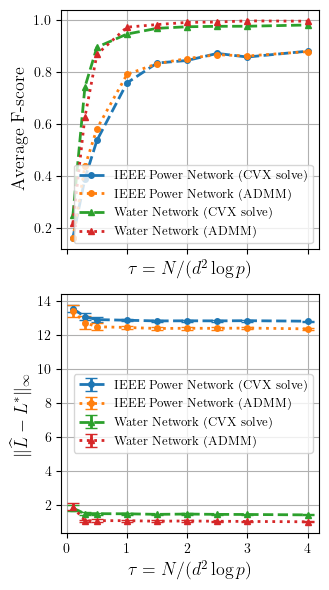

In [20]:
plot_f1_vs_sample_scaling()

p:30, d:4 tou: 0.1, N: 5
ADMM did not converge within max iterations.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 96.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 97.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 101.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 113.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 110.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 94.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 120.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 105.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 130.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 99.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 107.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 150.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 123.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 109.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 100.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 113.
p:30, d:4 tou: 0.1, N: 5
ADMM converged at iter 163.
p:30, d:4 tou: 0.1, N: 5
ADMM con

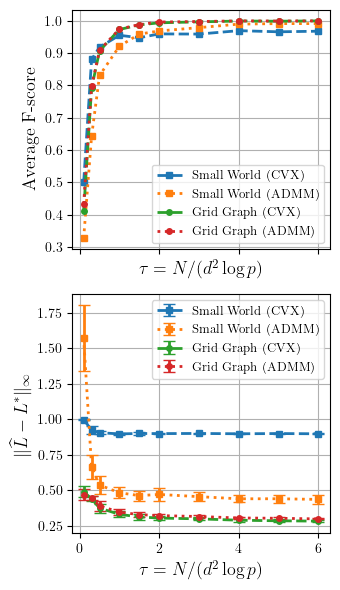

In [27]:
rho=1.0
max_iter=1000
tol=1e-4
threshold=1e-1
scaling_values=[0.1, 0.3, 0.5, 1, 1.5, 2, 3, 4, 5, 6]
num_trials=20
log_dir="experiment_scale_logs"


os.makedirs(log_dir, exist_ok=True)

fig, axs = plt.subplots(2, 1, figsize=(3.5, 6), sharex=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 7,
})

markers = {
    MatrixType.BUS_33_MODIFIED: "o",
    MatrixType.WATER_NETWORK: "^",
    MatrixType.GRID_GRAPH: "o",
    MatrixType.SMALL_WORLD: "s",
    MatrixType.SCALE_FREE: "D",
    MatrixType.ERDOS_RENYI: "^"
}
linestyles = {
    "SLNSCL": "dashed",
    "ADMM": "dotted"
}

legend_labels = {
    MatrixType.SCALE_FREE: "Scale Free",
    MatrixType.ERDOS_RENYI: "Erdős-Rényi",
    MatrixType.SMALL_WORLD: "Small World",
    MatrixType.GRID_GRAPH: "Grid Graph",
    MatrixType.BUS_33_MODIFIED: "IEEE Power Network",
    MatrixType.WATER_NETWORK: "Water Network",
}

admm_best_lam = {
    MatrixType.SCALE_FREE: 0.111,
    MatrixType.ERDOS_RENYI: 0.222,
    MatrixType.SMALL_WORLD: 0.333,
    MatrixType.GRID_GRAPH: 1,
    MatrixType.BUS_33_MODIFIED: 0.333,
    MatrixType.WATER_NETWORK: 0.222,
}

cvpxy_best_lam = {
    MatrixType.SCALE_FREE: 0.111,
    MatrixType.ERDOS_RENYI: 0.222,
    MatrixType.SMALL_WORLD: 0.889,
    MatrixType.GRID_GRAPH: 0.444,
    MatrixType.BUS_33_MODIFIED: 0.222,
    MatrixType.WATER_NETWORK: 0.222,
}

for matrix_type in [MatrixType.SMALL_WORLD, MatrixType.GRID_GRAPH]:
    B = load_B(matrix_type)
    ground_truth_adjacency = (B != 0).astype(int)
    mask_offdiag = ~np.eye(len(B), dtype=bool)

    f1_admm, f1_slnscl = [], []
    err_admm, err_slnscl, err_std_admm, err_std_slnscl = [], [], [], []

    for scale in scaling_values:
        f1_trials_admm = []
        f1_trials_slnscl = []
        err_trials_admm = []
        err_trials_slnscl = []

        for trial_id in range(num_trials):
            S, N = generate_sparse_covariance(B, sample_scaling=scale, random_seed=trial_id)

            # SLNSCL
            B_slnscl = slnscl_precision_matrix(S, cvpxy_best_lam[matrix_type], trial_id=trial_id, log_history=False)
            B_slnscl_thres = hard_threshold(B_slnscl, threshold)
            pred_slnscl = (B_slnscl_thres != 0).astype(int)
            f1_trials_slnscl.append(f1_score(ground_truth_adjacency[mask_offdiag], pred_slnscl[mask_offdiag]))
            err_trials_slnscl.append(np.max(np.abs(B_slnscl - B)[mask_offdiag]))

            # ADMM
            B_admm = admm_precision_matrix(S, admm_best_lam[matrix_type], rho=rho, max_iter=max_iter,
                                            abs_tol=tol, rel_tol=tol, log_history=False)
            B_admm_thres = hard_threshold(B_admm, threshold)
            pred_admm = (B_admm_thres != 0).astype(int)
            f1_trials_admm.append(f1_score(ground_truth_adjacency[mask_offdiag], pred_admm[mask_offdiag]))
            err_trials_admm.append(np.max(np.abs(B_admm - B)[mask_offdiag]))

        # Store means and stds
        f1_slnscl.append(np.mean(f1_trials_slnscl))
        f1_admm.append(np.mean(f1_trials_admm))
        err_slnscl.append(np.mean(err_trials_slnscl))
        err_admm.append(np.mean(err_trials_admm))
        err_std_slnscl.append(np.std(err_trials_slnscl))
        err_std_admm.append(np.std(err_trials_admm))

        print(f"{matrix_type.name}, scale={scale}, F1 SLNSCL={np.mean(f1_trials_slnscl):.3f}, F1 ADMM={np.mean(f1_trials_admm):.3f}")

    label = legend_labels[matrix_type]
    marker = markers[matrix_type]

    # F1 plot
    axs[0].plot(scaling_values, f1_slnscl, label=f"{label} (CVX)", linestyle=linestyles["SLNSCL"],
                marker=marker, linewidth=2, markersize=4)
    axs[0].plot(scaling_values, f1_admm, label=f"{label} (ADMM)", linestyle=linestyles["ADMM"],
                marker=marker, linewidth=2, markersize=4)

    # Error plot
    axs[1].errorbar(scaling_values, err_slnscl, yerr=err_std_slnscl, label=f"{label} (CVX)",
                    linestyle=linestyles["SLNSCL"], marker=marker, linewidth=2, capsize=4, markersize=4)
    axs[1].errorbar(scaling_values, err_admm, yerr=err_std_admm, label=f"{label} (ADMM)",
                    linestyle=linestyles["ADMM"], marker=marker, linewidth=2, capsize=4, markersize=4)

for ax in axs:
    ax.set_xlabel(r"$\tau = N/(d^2 \log p)$", fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True)

axs[0].set_ylabel("Average F-score", fontsize=13)
axs[1].set_ylabel(r"$\|\widehat{L} - L^*\|_{\infty}$", fontsize=13)

plt.tight_layout()
plt.savefig("scaling_vs_f1_error_comparison.png", dpi=600)
plt.show()

Real world estimates
















In [64]:
B_bus = load_B(MatrixType.BUS_33_MODIFIED)
S_bus, _ = generate_sparse_covariance(B_bus, sample_scaling=4)
B_water = load_B(MatrixType.WATER_NETWORK)
S_water, _ = generate_sparse_covariance(B_water, sample_scaling=4)

lambda_ = 0.1  # Regularization strength
rho = 1.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-5  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate_bus = admm_precision_matrix(S_bus, 0.278, rho, max_iter, tol)
B_estimate_water = admm_precision_matrix(S_water, 0.175, rho, max_iter, tol)


Minimum eigenvalue too small (-1.22e+00), adding 1 to diagonal elements.
Max degree in B 3
Max degree in B 5
Iteration 0, Error: 5.16e-01
Iteration 5, Error: 5.89e-16
Iteration 0, Error: 3.88e-01
Iteration 5, Error: 7.77e-16
Iteration 0, Error: 1.95e-01
Iteration 5, Error: 8.74e-16
Iteration 0, Error: 2.36e-01
Iteration 0, Error: 1.66e-01
Iteration 0, Error: 1.08e-01
Iteration 0, Error: 7.14e-02
Iteration 0, Error: 4.93e-02
Iteration 0, Error: 3.53e-02
Iteration 0, Error: 2.59e-02
Iteration 0, Error: 1.94e-02
Iteration 0, Error: 1.48e-02
Iteration 0, Error: 1.14e-02
Iteration 0, Error: 8.78e-03
Iteration 0, Error: 6.65e-03
Iteration 0, Error: 5.07e-03
Iteration 0, Error: 3.89e-03
Iteration 0, Error: 3.00e-03
Iteration 0, Error: 2.35e-03
Iteration 0, Error: 1.87e-03
Iteration 0, Error: 1.48e-03
Iteration 0, Error: 1.18e-03
Iteration 0, Error: 9.35e-04
Iteration 0, Error: 7.44e-04
Iteration 0, Error: 5.92e-04
Iteration 0, Error: 4.72e-04
Iteration 0, Error: 3.76e-04
Iteration 0, Error: 3

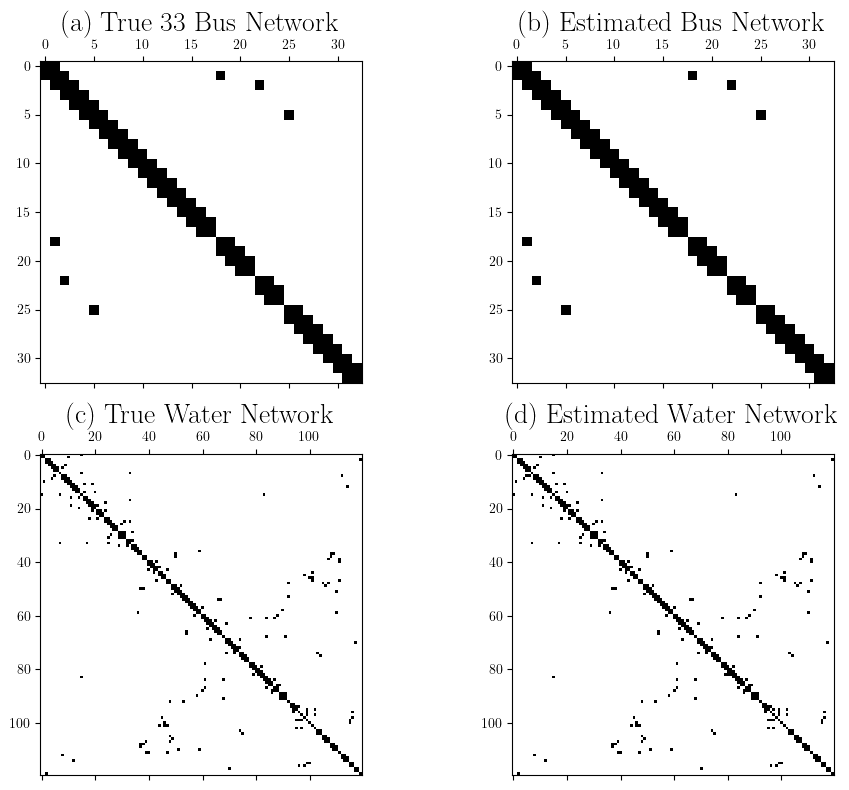

In [ ]:
import matplotlib.pyplot as plt

font_size = 20
# Create a new figure
plt.figure(figsize=(10, 8))

# Subplot 1: True B_bus
plt.subplot(2, 2, 1)
plt.spy(B_bus)
plt.title('(a) True 33 Bus Network', fontsize=font_size)

# Subplot 2: Estimated B_bus after thresholding
plt.subplot(2, 2, 2)
plt.spy(hard_threshold(B_estimate_bus, 0.1))
plt.title('(b) Estimated Bus Network', fontsize=font_size)

# Subplot 3: True B_water
plt.subplot(2, 2, 3)
plt.spy(B_water)
plt.title('(c) True Water Network', fontsize=font_size)

# Subplot 4: Estimated B_water after thresholding
plt.subplot(2, 2, 4)
plt.spy(hard_threshold(B_estimate_water, 0.1))
plt.title('(d) Estimated Water Network', fontsize=font_size)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


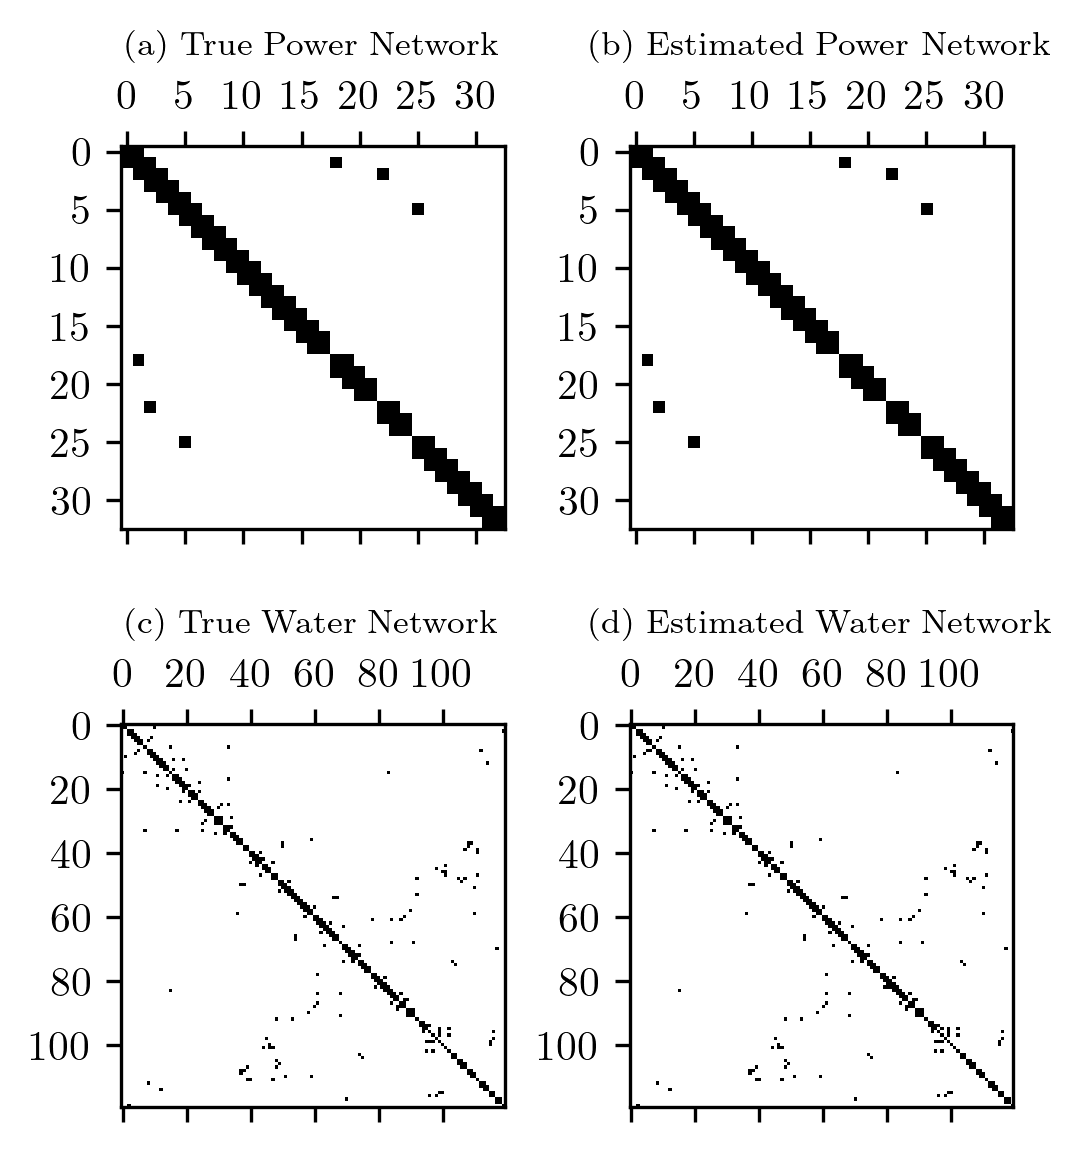

In [83]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(3.5, 4), dpi=300)

# Font size for subplot titles
title_fontsize = 8  # small but readable in IEEE column
title_pad = 6       # slight spacing above subplot title

axs[0, 0].spy(B_bus)
axs[0, 0].set_title('(a) True Power Network ', fontsize=title_fontsize, pad=title_pad)

axs[0, 1].spy(hard_threshold(B_estimate_bus, 0.1))
axs[0, 1].set_title('(b) Estimated Power Network', fontsize=title_fontsize, pad=title_pad)

axs[1, 0].spy(B_water)
axs[1, 0].set_title('(c) True Water Network', fontsize=title_fontsize, pad=title_pad)

axs[1, 1].spy(hard_threshold(B_estimate_water, 0.1))
axs[1, 1].set_title('(d) Estimated Water Network', fontsize=title_fontsize, pad=title_pad)

# Reduce space between subplots
plt.tight_layout(pad=0.8)  # Adjust if you want even tighter layout

# Save as high-res image for IEEE paper
plt.savefig("ieee_column_subplots.pdf", bbox_inches='tight')  # or use .png/.eps
plt.show()
